In [ ]:
import zipfile

path_to_zip_file = '/content/datadenekSON.zip'

directory_to_extract_to = '/content'

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

51877672/51877672 [==============================] - 0s 0us/step
Epoch 1/50
65/64 [==============================] - ETA: 0s - loss: 8.0986 - accuracy: 0.8531
Epoch 1: val_accuracy improved from -inf to 0.91723, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - 53s 479ms/step - loss: 8.0986 - accuracy: 0.8531 - val_loss: 7.0840 - val_accuracy: 0.9172 - lr: 1.0000e-04
Epoch 2/50
65/64 [==============================] - ETA: 0s - loss: 6.3614 - accuracy: 0.9300
Epoch 2: val_accuracy improved from 0.91723 to 0.95011, saving model to best_model.h5
64/64 [==============================] - 15s 230ms/step - loss: 6.3614 - accuracy: 0.9300 - val_loss: 5.6401 - val_accuracy: 0.9501 - lr: 1.0000e-04
Epoch 3/50
65/64 [==============================] - ETA: 0s - loss: 5.0834 - accuracy: 0.9523
Epoch 3: val_accuracy improved from 0.95011 to 0.96259, saving model to best_model.h5
64/64 [==============================] - 15s 232ms/step - loss: 5.0834 - accuracy: 0.9523 - val_loss: 4.5181 - val_accuracy: 0.9626 - lr: 1.0000e-04
Epoch 4/50
65/64 [==============================] - ETA: 0s - loss: 4.1038 - accuracy: 0.9674
Epoch 4: val_accuracy improved from 0.96259 to 0.97846, saving model to best_model.h5
64/64 [======

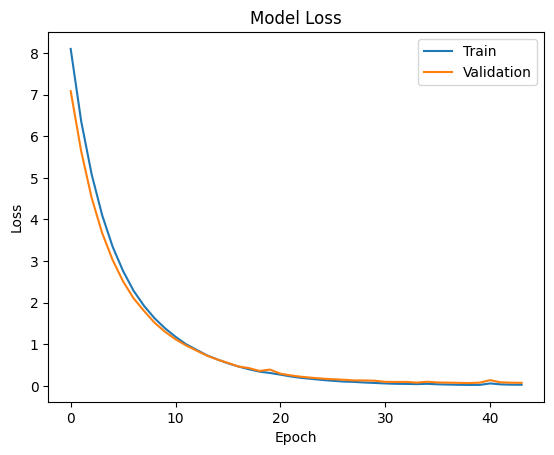

28/28 [==============================] - 6s 56ms/step
Precision: 0.99
Recall: 0.98
F1 Score: 0.98


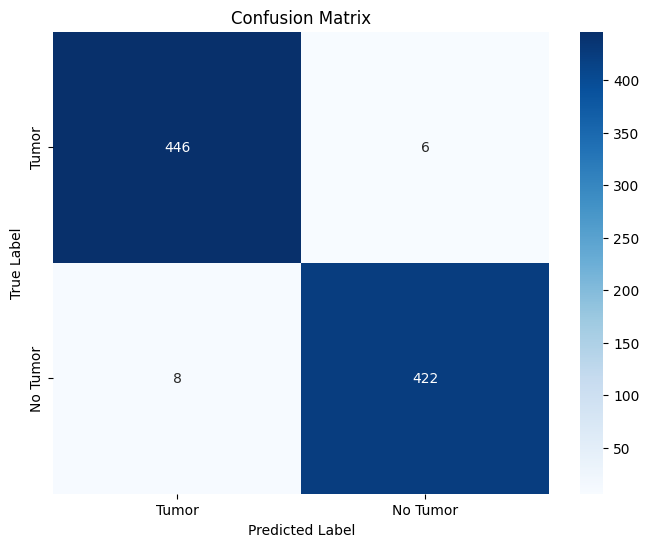

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet169, MobileNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

unfreeze_layers_densenet = 20
unfreeze_layers_mobilenet = 5

train_yes_path = '/content/datadenek2/beyin/veri/yes1'
train_no_path = '/content/datadenek2/beyin/veri/no1'

data = []
labels = []

for r, d, f in os.walk(train_yes_path):
    for file in f:
        if file.endswith('.jpg'):
            img_path = os.path.join(r, file)
            img = Image.open(img_path)
            img = img.resize((128, 128))
            img = np.array(img)
            if img.shape == (128, 128, 3):
                data.append(img)
                labels.append(0)

for r, d, f in os.walk(train_no_path):
    for file in f:
        if file.endswith('.jpg'):
            img_path = os.path.join(r, file)
            img = Image.open(img_path)
            img = img.resize((128, 128))
            img = np.array(img)
            if img.shape == (128, 128, 3):
                data.append(img)
                labels.append(1)

if len(data) == 0 or len(labels) == 0:
    raise ValueError("Data or labels are empty. Please check the data loading process.")

data = np.array(data)
labels = np.array(labels)

encoder = OneHotEncoder()
labels = encoder.fit_transform(labels.reshape(-1, 1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, shuffle=True, random_state=0)

x_train = x_train / 255.0
x_test = x_test / 255.0

train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
)

train_datagen.fit(x_train)

mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in mobilenet.layers:
    layer.trainable = False

for layer in mobilenet.layers[-unfreeze_layers_mobilenet:]:
    layer.trainable = True


densenet169 = DenseNet169(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in densenet169.layers:
    layer.trainable = False

for layer in densenet169.layers[-unfreeze_layers_densenet:]:
    layer.trainable = True

mobilenet_output = mobilenet.output
densenet169_output = densenet169.output

mobilenet_output = layers.GlobalAveragePooling2D()(mobilenet_output)
densenet169_output = layers.GlobalAveragePooling2D()(densenet169_output)

merged = layers.concatenate([mobilenet_output, densenet169_output])

x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(merged)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation='sigmoid')(x)

model = Model(inputs=[mobilenet.input, densenet169.input], outputs=outputs)

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])


checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)


early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = model.fit(
    train_datagen.flow([x_train, x_train], y_train, batch_size=32),
    steps_per_epoch=len(x_train) / 32,
    epochs=50,
    validation_data=([x_test, x_test], y_test),
    callbacks=[checkpoint, lr_scheduler, early_stopping]
)

evaluation_results = model.evaluate([x_test, x_test], y_test)
accuracy = evaluation_results[1]
print("Model Accuracy on Test Set: {:.2f}%".format(accuracy * 100))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

y_pred = model.predict([x_test, x_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

precision = precision_score(y_true_classes, y_pred_classes)
recall = recall_score(y_true_classes, y_pred_classes)
f1 = f1_score(y_true_classes, y_pred_classes)

print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Tumor', 'No Tumor'], yticklabels=['Tumor', 'No Tumor'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

Epoch 1/50
65/64 [==============================] - ETA: 0s - loss: 8.0664 - accuracy: 0.8478
Epoch 1: val_accuracy improved from -inf to 0.91950, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - 36s 273ms/step - loss: 8.0664 - accuracy: 0.8478 - val_loss: 7.0154 - val_accuracy: 0.9195 - lr: 1.0000e-04
Epoch 2/50
65/64 [==============================] - ETA: 0s - loss: 6.2246 - accuracy: 0.9475
Epoch 2: val_accuracy did not improve from 0.91950
64/64 [==============================] - 14s 207ms/step - loss: 6.2246 - accuracy: 0.9475 - val_loss: 5.5462 - val_accuracy: 0.9184 - lr: 1.0000e-04
Epoch 3/50
65/64 [==============================] - ETA: 0s - loss: 4.9277 - accuracy: 0.9611
Epoch 3: val_accuracy improved from 0.91950 to 0.97166, saving model to best_model.h5
64/64 [==============================] - 13s 200ms/step - loss: 4.9277 - accuracy: 0.9611 - val_loss: 4.3561 - val_accuracy: 0.9717 - lr: 1.0000e-04
Epoch 4/50
65/64 [==============================] - ETA: 0s - loss: 3.9330 - accuracy: 0.9708
Epoch 4: val_accuracy improved from 0.97166 to 0.98186, saving model to best_model.h5
64/64 [==============================] - 13s 201

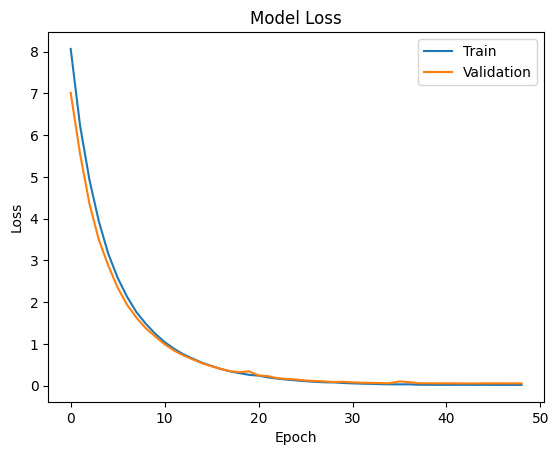

28/28 [==============================] - 4s 57ms/step
Precision: 0.99
Recall: 0.99
F1 Score: 0.99


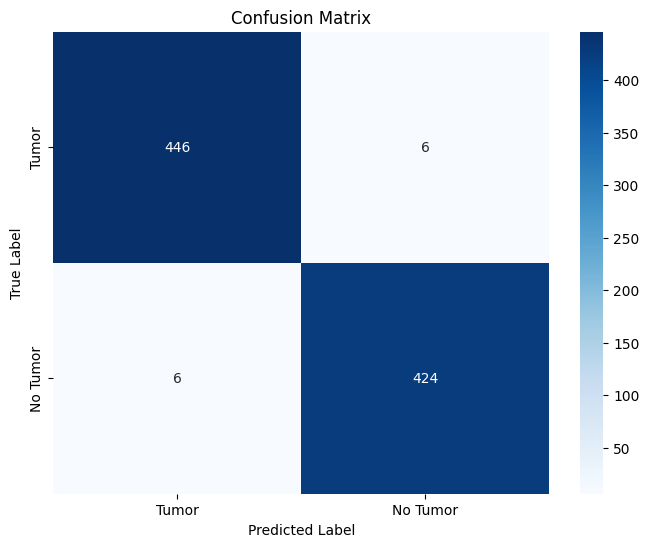

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet169, MobileNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

# Number of layers to unfreeze
unfreeze_layers_densenet = 20
unfreeze_layers_mobilenet = 10

# Paths to training data
train_yes_path = '/content/datadenek2/beyin/veri/yes1'
train_no_path = '/content/datadenek2/beyin/veri/no1'

# Load and process images
data = []
labels = []

# Process 'Yes' (tumor) images
for r, d, f in os.walk(train_yes_path):
    for file in f:
        if file.endswith('.jpg'):
            img_path = os.path.join(r, file)
            img = Image.open(img_path)
            img = img.resize((128, 128))
            img = np.array(img)
            if img.shape == (128, 128, 3):
                data.append(img)
                labels.append(0)  # 'yes' class

# Process 'No' (no tumor) images
for r, d, f in os.walk(train_no_path):
    for file in f:
        if file.endswith('.jpg'):
            img_path = os.path.join(r, file)
            img = Image.open(img_path)
            img = img.resize((128, 128))
            img = np.array(img)
            if img.shape == (128, 128, 3):
                data.append(img)
                labels.append(1)  # 'no' class

# Check if data and labels are correctly loaded
if len(data) == 0 or len(labels) == 0:
    raise ValueError("Data or labels are empty. Please check the data loading process.")

data = np.array(data)
labels = np.array(labels)

# One-hot encode labels
encoder = OneHotEncoder()
labels = encoder.fit_transform(labels.reshape(-1, 1)).toarray()

# Split data into 70% training and 30% testing
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, shuffle=True, random_state=0)

# Normalize image data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
)

train_datagen.fit(x_train)

# Define MobileNet model
mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
# Freeze all layers
for layer in mobilenet.layers:
    layer.trainable = False
# Unfreeze the last specified layers
for layer in mobilenet.layers[-unfreeze_layers_mobilenet:]:
    layer.trainable = True

# Define DenseNet169 model
densenet169 = DenseNet169(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
# Freeze all layers
for layer in densenet169.layers:
    layer.trainable = False
# Unfreeze the last specified layers
for layer in densenet169.layers[-unfreeze_layers_densenet:]:
    layer.trainable = True

# Get outputs of MobileNet and DenseNet169 models
mobilenet_output = mobilenet.output
densenet169_output = densenet169.output

# Apply global average pooling to outputs
mobilenet_output = layers.GlobalAveragePooling2D()(mobilenet_output)
densenet169_output = layers.GlobalAveragePooling2D()(densenet169_output)

# Concatenate the outputs
merged = layers.concatenate([mobilenet_output, densenet169_output])

# Add custom layers
x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(merged)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation='sigmoid')(x)

# Create the full model
model = Model(inputs=[mobilenet.input, densenet169.input], outputs=outputs)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

# Model Checkpoint
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Reduce Learning Rate on Plateau
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Train the model
history = model.fit(
    train_datagen.flow([x_train, x_train], y_train, batch_size=32),
    steps_per_epoch=len(x_train) / 32,
    epochs=50,
    validation_data=([x_test, x_test], y_test),
    callbacks=[checkpoint, lr_scheduler, early_stopping]
)

# Evaluate the model
evaluation_results = model.evaluate([x_test, x_test], y_test)
accuracy = evaluation_results[1]
print("Model Accuracy on Test Set: {:.2f}%".format(accuracy * 100))

# Plot the loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Calculate Precision, Recall, and F1 Score
y_pred = model.predict([x_test, x_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

precision = precision_score(y_true_classes, y_pred_classes)
recall = recall_score(y_true_classes, y_pred_classes)
f1 = f1_score(y_true_classes, y_pred_classes)

print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Tumor', 'No Tumor'], yticklabels=['Tumor', 'No Tumor'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()
